# Autodiff demo

Following is the demo for small library for Reverse-mode Automatic Differentiation, to be used in Neural network training. I wrote this as a solution of one of the assignments in Deep learning course from University of Washington. https://github.com/dlsys-course/assignment1. I am not enrolled in this course. This was only for learning purpose.

This notebook demos the comparison between this library and Tensorflow library in training of a small neural network doing the classification of images among 3 classes. It demos how the loss decreases after each epoch of training and results almost matches with Tensorflow execution.

**That assignment had skeleton code for:**
- Node, Op and Executor classes (run and gradients method)
- Implementions for AddOp, AddByConstOp

**I Implemented:**
- Operations like 
    - SubOp, MulOp, AddByConstOp, MulByConstOp, PlaceholderOp   
    - MatMulOp, TransposeOp    
    - OnesLikeOp, ZerosLikeOp
    - ExpXOp, InverseOp, ReduceMeanOp
    - SizeOp, LogOp, AssignOp
    - SoftmaxOp, Softmax_With_Cross_EntropyOp
    - SigmoidOp, Sigmoid_With_Cross_EntropyOp
    - ReluOp, Relu_DerivativeOp
- Gradient computation of trainable variable w.r.t. cost
- Executor.run method which computes the values for a given subset of nodes in a computation graph.
- Optimizer such as GradientDescentOptimizer

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from pathlib import Path, PurePath, WindowsPath
from operator import itemgetter
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, convert_to_one_hot, predict

from image_dataset_load import *

# Importing autodiff library
import autodiff as ad
import train as tr  # this module has GradientDescentOptimizer class
import initializers as init

%matplotlib inline

In [2]:
def show_image(data, label, ind, dimension, print_class=False):
    w, h = dimension
    test_image = data[:, ind].reshape(h, w, 3)
    test_label = label[:, ind]    
    if print_class:
        print(test_label, np.argmax(test_label))
    plt.imshow(test_image)
    plt.show()
    return np.argmax(test_label)

In [3]:
def one_hot(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    
    C = tf.constant(C, name='C')
    
    one_hot_matrix = tf.one_hot(labels, C, axis=0)
    
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()
    
    return one_hot    

Loading the 3 class of images for training

In [4]:
#X, Y = load_img_dataset()
X, Y = loadImgsLabels([(r"test\size_80x80\1", 0), (r"test\size_80x80\2", 1), (r"test\size_80x80\3", 2)], (80, 80))
X, Y = randomize_std(X, Y)

num_classes = 3

train_X, train_Y, test_X, test_Y = split_train_test(X, Y, 700)

train_Y = one_hot(train_Y, num_classes)
test_Y = one_hot(test_Y, num_classes)

train_Y = train_Y.reshape((num_classes, train_Y.shape[2]))
test_Y = test_Y.reshape((num_classes, test_Y.shape[2]))

print("train_X shape, train_Y shape ", train_X.shape, train_Y.shape)
print("test_X shape, test_Y shape ", test_X.shape, test_Y.shape)

(310, 80, 80, 3)
(653, 80, 80, 3)
(896, 80, 80, 3)
train_X shape, train_Y shape  (19200, 700) (3, 700)
test_X shape, test_Y shape  (19200, 196) (3, 196)


In [5]:
def random_mini_batches(X, Y, batch_size=10, seed=0):    
    """
    Shuffle the input X and produce mini batches in size of batch_size
    
    Arguments:
    X - input.  dimension ( input features, no of examples )
    Y - labels
    batch_size - size of the mini-batch
    seed - seed to randomize the X before splitting it into mini-batches

    Returns:
    batches of X and Y split into size of batch_size
    """   
    
    
    np.random.seed(seed)
    
    m = X.shape[1]
    permute = list(np.random.permutation(m))
    
    X = X[:, permute]
    Y = Y[:, permute]     
    
    
    a = list(range(0, m, batch_size))
    b = list(range(batch_size, m, batch_size))    
    b.append(m)
    
    for (start, end) in zip(a, b):        
        yield X[:, start:end], Y[:, start:end]

Setting the training variables, computaion graph and training the model using **autodiff** library

In [6]:
learn_rate = 0.005

W1 = ad.Variable(name = "W1", shape = (100, train_X.shape[0]), initializer = init.xavier_initializer())
W2 = ad.Variable(name = "W2", shape = (20, 100), initializer = init.xavier_initializer())
W3 = ad.Variable(name = "W3", shape = (3, 20), initializer = init.xavier_initializer())

x, labels = ad.placeholder(name = "x"), ad.placeholder(name = "labels")

In [7]:
Z1 = ad.matmul(W1, x)
A1 = ad.relu(Z1)
Z2 = ad.matmul(W2, A1)
A2 = ad.relu(Z2)
Z3 = ad.matmul(W3, A2)

cost = ad.reduce_mean( ad.softmax_with_cross_entropy(Z3, labels) )
optimizer = tr.GradientDescentOptimizer(learn_rate).minimize(cost)
optimizer.append(cost)
executor = ad.Executor(optimizer)

seed = 0
costs = []   # to track the costs
epochs = 50
mini_batch_size = 10
    
for epoch in range(epochs):
    epoch_cost = 0
    seed += 1
    
    for (batch_X, batch_Y) in random_mini_batches(train_X, train_Y, mini_batch_size, seed):
        curr_batch_size = batch_X.shape[1]
        
        _, minibatch_cost = executor.run(feed_dict = {x : batch_X, labels : batch_Y})        
        epoch_cost += minibatch_cost/curr_batch_size
        
    print("Cost after epoch %i: %f" % (epoch+1, epoch_cost))                

trainable_vars  [W1, W2, W3]
Cost after epoch 1: 12.821472
Cost after epoch 2: 10.853068
Cost after epoch 3: 8.807595
Cost after epoch 4: 8.930385
Cost after epoch 5: 8.021197
Cost after epoch 6: 7.290488
Cost after epoch 7: 7.405478
Cost after epoch 8: 6.796811
Cost after epoch 9: 6.569471
Cost after epoch 10: 5.840512
Cost after epoch 11: 6.227665
Cost after epoch 12: 5.440793
Cost after epoch 13: 5.574930
Cost after epoch 14: 5.067640
Cost after epoch 15: 4.978729
Cost after epoch 16: 4.560718
Cost after epoch 17: 4.667846
Cost after epoch 18: 4.854133
Cost after epoch 19: 4.834579
Cost after epoch 20: 4.066814
Cost after epoch 21: 4.006650
Cost after epoch 22: 3.910609
Cost after epoch 23: 3.240038
Cost after epoch 24: 3.501762
Cost after epoch 25: 2.805002
Cost after epoch 26: 3.898406
Cost after epoch 27: 3.033619
Cost after epoch 28: 2.814546
Cost after epoch 29: 2.495004
Cost after epoch 30: 2.709383
Cost after epoch 31: 2.337458
Cost after epoch 32: 1.938666
Cost after epoch 3

Setting the training variables, computaion graph and training the model using **Tensorflow** library

In [8]:
def create_placeholders(num_features, classes):
    """
    Creates the placeholders for training data X and traininig class labels Y
                     
    Arguments:
    num_inputs -- no. of input features 
    classes -- number of classes
    
    Returns: 
    X and Y placeholders
    """
    
    X = tf.placeholder(tf.float32, shape=(num_features, None), name='X')
    Y = tf.placeholder(tf.float32, shape=(classes, None), name='Y')
    
    return X, Y    

In [9]:
def initialize_parameters(num_features, classes):
    """
    initialize the wts and biases for the network
    
    Arguments:
    num_inputs -- no. of input features 
    classes -- number of classes
    
    Returns :
    dictionary of tensors containing W1, b1, W2, b2, W3, b3    
    """
    
    random_init = tf.random_normal_initializer()
    xavier_init = tf.contrib.layers.xavier_initializer(seed = 1)
    
    W1 = tf.get_variable("W1", [100, num_features], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [300, 1], initializer = tf.zeros_initializer())
    
    W2 = tf.get_variable("W2", [20, 100], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [100, 1], initializer = tf.zeros_initializer())
    
    W3 = tf.get_variable("W3", [classes, 20], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [classes, 1], initializer = tf.zeros_initializer())

    parameters = {"W1":W1, "b1":b1,
                  "W2":W2, "b2":b2,
                  "W3":W3, "b3":b3
                 }
    
    return parameters

In [10]:
def forward_prop(X, parameters):
    """
    Computes the forward propagation.
    
    Arguments:
    X -- input data of dimension ( input features, no of examples )
    parameters -- training wts and biases
    
    Returns: 
    linear output tensor from last unit   
    """
    
    W1, b1 = parameters["W1"], parameters["b1"]
    W2, b2 = parameters["W2"], parameters["b2"]
    W3, b3 = parameters["W3"], parameters["b3"]

    Z1 = tf.matmul(W1, X) #+ b1
    A1 = tf.nn.relu(Z1)
    Z2 = tf.matmul(W2, A1) #+ b2
    A2 = tf.nn.relu(Z2)
    Z3 = tf.matmul(W3, A2) #+ b3

    return Z3

In [11]:
def compute_cost(Z3, Y, l2_regularize, beta, parameters):
    """
    computes the softmax cross entropy cost

    Arguments :
    Z3 - linear output from last unit of network (classes, batch size)
    Y -  one hot encoding of labels (classes, batch size)

    Returns :
    Tensor of the cost function 
    """

    # to fit the requirement of tf.nn.softmax_cross_entropy_with_logits... . this function expects the 
    # inputs in dimension (batch size, classes)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    regularizer = 0
    if l2_regularize:
        W1 = parameters["W1"]
        W2 = parameters["W2"]
        W3 = parameters["W3"]
        
        regularizer = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3)        
        

    cost = tf.reduce_mean( 
          tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels) + beta*regularizer )

    return cost

In [12]:
def accuracy(Z3, Y1, train_X, train_Y, test_X, test_Y):
    # Calculate the correct predictions
    correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y1))

    # Calculate accuracy on the test set
    accuracy1 = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    print ("Train Accuracy:", accuracy1.eval({X: train_X, Y: train_Y}))
    print ("Test Accuracy:", accuracy1.eval({X: test_X, Y: test_Y}))

In [13]:
def train(train_X, train_Y, dev_X, dev_Y, test_X, test_Y, learning_rate = 0.005, 
          num_epochs = 500, mini_batch_size = 10, 
          l2_regularize=False, beta=0.01):
    
    print("learning_rate %f, num_epochs %i, mini_batch_size %i, l2_regularize %s, beta %f" % 
          (learning_rate, num_epochs, mini_batch_size, l2_regularize, beta))


    ops.reset_default_graph()

    num_features, classes = train_X.shape[0], train_Y.shape[0]

    X, Y = create_placeholders(num_features, classes)

    parameters = initialize_parameters(num_features, classes)

    Z3 = forward_prop(X, parameters)

    cost = compute_cost(Z3, Y, l2_regularize, beta, parameters)

    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    
    correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    init = tf.global_variables_initializer()

    # train 
    seed = 0
    costs = []   # to track the costs
    
    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(num_epochs):
            epoch_cost = 0
            seed += 1

            for (batch_X, batch_Y) in random_mini_batches(train_X, train_Y, mini_batch_size, seed):
                curr_batch_size = batch_X.shape[1]

                _, minibatch_cost = sess.run([optimizer, cost], feed_dict = {X:batch_X, Y:batch_Y})

                epoch_cost += minibatch_cost/curr_batch_size

            print("Cost after epoch %i: %f" % (epoch+1, epoch_cost))
            if epoch % 5 == 0:
                costs.append(epoch_cost)

        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        parameters = sess.run(parameters)
        
        print ("Test Accuracy: ", accuracy.eval({X: dev_X, Y: dev_Y}))
        
    
    prediction = tf.argmax(Z3)       
    
    return parameters, prediction  

learning_rate 0.005000, num_epochs 50, mini_batch_size 10, l2_regularize False, beta 0.020000
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Cost after epoch 1: 7.061410
Cost after epoch 2: 5.622121
Cost after epoch 3: 4.789546
Cost after epoch 4: 4.786476
Cost after epoch 5: 4.442242
Cost after epoch 6: 3.997604
Cost after epoch 7: 4.208305
Cost after epoch 8: 3.738872
Cost after epoch 9: 3.597192
Cost after epoch 10: 3.218843
Cost after epoch 11: 3.436869
Cost after epoch 12: 2.977800
Cost after epoch 13: 2.980100
Cost after epoch 14: 2.843598
Cost after epoch 15: 2.752924
Cost after epoch 16: 2.586309
Cost after epoch 17: 2.521039
Cost after epoch 18: 2.845722
Cost after epoch 19: 2.630410
Cost after epoch 20: 2.343413
Cost after epoch 21: 2.231158
Cost after epoch 22: 2.070470
Cost after epoch 23: 1.799476
Cost after epoch 24: 1.893818
Cos

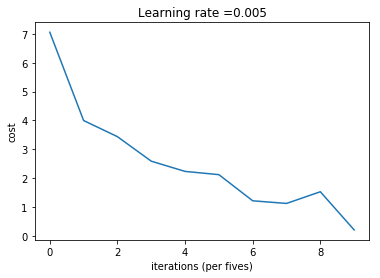

Test Accuracy:  0.80102


In [14]:
parameters, prediction = train(train_X, train_Y, test_X, test_Y, None, None,
                   num_epochs=50, learning_rate = 0.005, 
                   mini_batch_size = 10, l2_regularize=False, beta=0.02)